In [1]:
import tensorflow as tf
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [11]:
# Imports 3 years of BTC daily data from yahoo finance
BTC_df = get_data("BTC-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1wk")
df = BTC_df.iloc[:,0:-1]
df.head()

,open,high,low,close,adjclose,volume
2019-06-24,11931.991211,12178.383789,10799.008789,10817.155273,10817.155273,27256473494
2019-07-01,10796.930664,12006.075195,9737.884766,11450.846680,11450.846680,181410821667
2019-07-08,11446.596680,13129.529297,10234.576172,10256.058594,10256.058594,180936684097
2019-07-15,10257.838867,11052.766602,9163.134766,10599.105469,10599.105469,157356814406
2019-07-22,10596.948242,10651.791016,9252.296875,9552.860352,9552.860352,112459229432


In [12]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through btc data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [13]:
# Defines window size
window_size=10

In [14]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

array([[10817.15527344, 11450.84667969, 10256.05859375, ...,
        10345.81054688, 10138.51757812,  9757.97070312],
       [11450.84667969, 10256.05859375, 10599.10546875, ...,
        10138.51757812,  9757.97070312, 10441.27636719],
       [10256.05859375, 10599.10546875,  9552.86035156, ...,
         9757.97070312, 10441.27636719, 10347.71289062],
       ...,
       [46453.56640625, 42207.671875  , 39716.953125  , ...,
        30323.72265625, 29445.95703125, 29906.66210938],
       [42207.671875  , 39716.953125  , 39469.29296875, ...,
        29445.95703125, 29906.66210938, 26762.6484375 ],
       [39716.953125  , 39469.29296875, 38469.09375   , ...,
        29906.66210938, 26762.6484375 , 20553.27148438]])

array([[10441.27636719],
       [10347.71289062],
       [10070.39257812],
       [ 8104.18554688],
       [ 7988.15576172],
       [ 8321.00585938],
       [ 8222.078125  ],
       [ 9551.71484375],
       [ 9235.35449219],
       [ 9055.52636719],
       [ 8577.97558594],
       [ 7047.91699219],
       [ 7424.29248047],
       [ 7564.34521484],
       [ 7152.30175781],
       [ 7511.58886719],
       [ 7422.65283203],
       [ 7411.31738281],
       [ 8192.49414062],
       [ 8706.24511719],
       [ 8596.83007812],
       [ 9344.36523438],
       [10116.67382812],
       [ 9934.43359375],
       [ 9924.515625  ],
       [ 8562.45410156],
       [ 8108.11621094],
       [ 5392.31494141],
       [ 5830.25488281],
       [ 5922.04296875],
       [ 6791.12939453],
       [ 6971.09179688],
       [ 7189.42480469],
       [ 7679.8671875 ],
       [ 8897.46875   ],
       [ 8756.43066406],
       [ 9670.73925781],
       [ 8790.36816406],
       [ 9461.05859375],
       [ 9758.85253906],


In [15]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [16]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [17]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

(102, 10, 1)

(45, 10, 1)

In [18]:
# Creates neural network
model_btc=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model_btc.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_btc.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model_btc.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_btc.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model_btc.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model_btc.add(output_layer)

2022-07-14 16:06:42.970027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Compiles model
model_btc.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [20]:
# Provides summary of model
model_btc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 10, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-traina

In [21]:
model_btc.fit(X_train, y_train, epochs=50)

Epoch 1/50
4/4 [==============================] - 4s 15ms/step - loss: 0.1413 - mean_squared_error: 0.1413
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0908 - mean_squared_error: 0.0908
Epoch 3/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0511 - mean_squared_error: 0.0511
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 5/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0361 - mean_squared_error: 0.0361
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0314 - mean_squared_error: 0.0314
Epoch 7/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 8/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0225 - mean_squared_error: 0.0225
Epoch 9/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 10/50
4/4 [======================

2/2 [==============================] - 1s 4ms/step


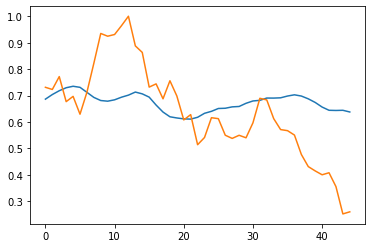

In [22]:
predictions = model_btc.predict(X_test)
results = pd.DataFrame({'predictions':predictions.ravel(),'actual':y_test.ravel()})
plt.plot(results)